# 패럿 3조 
### 권예진, 신동호, 조민석, 조수민
### 멘토 : 한성환

## 1. 피드백 포함 데이터 전처리
* 인플레이션을 고려한 income 수정
* 모든 feature에 대한 데이터 검토 후 전처리 
* 무직자와 재직자 분류

### 2. 가설 설정
* 재직자의 경우 : company size가 income에 큰 영향을 준다
* 무직자의 경우 : family member가 income에 큰 영향을 준다

### 2. 모델 생성
* XGBoost, LightGBM,Catboost

### 3. 모델 결과에 따른 데이터 전처리 재 진행 및 파라미터 수정

### 4. 모델 완성
* Ensemble 이용

### 5. 결론 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("Kor_income.csv", encoding = "cp949")
cpi_df = pd.read_excel("Kor_cpi.xlsx", sheet_name=0, index_col=0)#통계청의 소비자물가지수 자료

### unamed 칼럼 삭제 (중간 발표에 때와 추가해서 column 삭제)

In [2]:
del df['Unnamed: 0']
del df['id']
del df['wave']
del df['religion'] #new!
df

,year,region,family_member,gender,year_born,education_level,marriage,occupation,company_size,reason_none_worker,income
0,2005,3,1,2,1940,2,2,617,1,,460.000000
1,2018,4,3,1,1939,5,1,,,9,1713.000000
2,2012,2,3,1,1967,6,3,510,1,,2854.000000
3,2011,4,5,1,1947,3,1,611,1,,4290.000000
4,2017,4,2,1,1940,2,1,,,10,1608.000000
...,...,...,...,...,...,...,...,...,...,...,...
78923,2007,2,4,1,1965,5,1,941,5,,5860.000000
78924,2006,2,4,1,1972,5,1,512,2,,3744.000000
78925,2006,2,4,1,1941,2,1,,,7,2837.441215
78926,2018,7,1,2,1936,3,2,,,10,1697.000000


## income 인플레이션 고려하여 대체
### 실제 income을 대체 하지 않았을 경우 RMSE 수치가 2500정도 나오는 것으로 확인

In [3]:
cpi_df.rename(columns={'소비자물가 총지수(2020=100)' : 'cpi'}, inplace = True)
#통계청 자료 전처리
cpi_df = cpi_df.iloc[[1, 2], :]
cpi_df = cpi_df.dropna(axis=1)
cpi_df = cpi_df.T
cpi_df = cpi_df.reset_index(drop=True)
cpi_df.columns = ["year", "cpi"]
cpi_df['year'] = cpi_df['year'].astype(int)
cpi_df['cpi'] = cpi_df['cpi'].astype(float)

print(cpi_df)

    year   cpi
0   2005  74.4
1   2006  76.1
2   2007  78.0
3   2008  81.7
4   2009  83.9
5   2010  86.4
6   2011  89.9
7   2012  91.8
8   2013  93.0
9   2014  94.2
10  2015  94.9
11  2016  95.8
12  2017  97.6
13  2018  99.1


In [4]:
cpi_dict = cpi_df.set_index('year')['cpi'].to_dict()
# 인플레이션 적용
cpi_2020 = 100.0 #기준

# 인플레이션 데이터를 딕셔너리 형태로 변환
cpi_dict = dict(zip(cpi_df["year"], cpi_df["cpi"]))

# 인플레이션을 고려해 income 데이터를 수정
for index, row in df.iterrows():
    year = row["year"]
    income = row["income"]
    inflation_rate = cpi_2020 / cpi_dict[year]
    df.at[index, "income"] = income * inflation_rate

### 이상치 값을 boxplot을 이용하여 절단

<AxesSubplot:ylabel='income'>

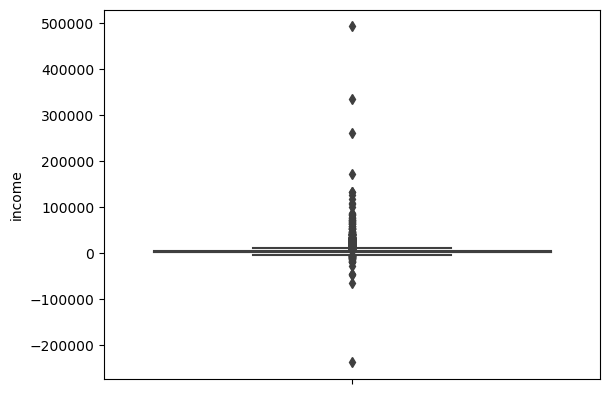

In [5]:
sns.boxplot(x=None, y="income", data=df)

<AxesSubplot:ylabel='income'>

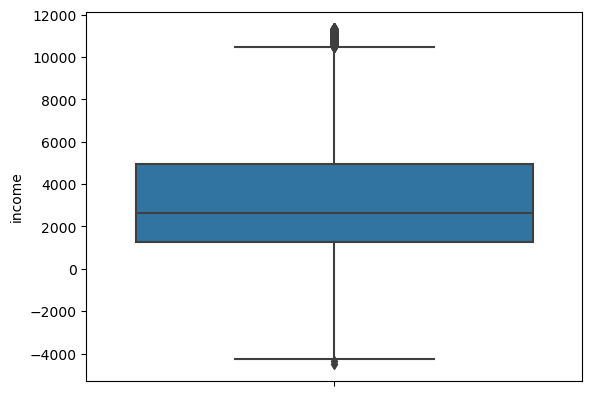

In [6]:
Q1 = df['income'].quantile(0.25) #income에서 1분위 계산
Q3 = df['income'].quantile(0.75) #income에서 3분위 계산
IQR = Q3 - Q1
df = df[(df['income'] >= Q1 - 1.5*IQR) & (df['income'] <= Q3 + 1.5*IQR)] #이상치 제거 진행

sns.boxplot(x=None, y="income", data=df)

### year age로 바꾸기

In [7]:
df['year_born'] = df['year']-df['year_born']+1
df.rename(columns={'year_born' : 'age'}, inplace = True)

/var/folders/1s/tzyglg092tj7kzxy4627gr2w0000gp/T/ipykernel_62452/848417472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_born'] = df['year']-df['year_born']+1
/var/folders/1s/tzyglg092tj7kzxy4627gr2w0000gp/T/ipykernel_62452/848417472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'year_born' : 'age'}, inplace = True)


In [8]:
df[df['age']<20]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
4782,2005,7,1,1,14,4,0,,,,248.655914
18530,2016,6,1,1,19,5,5,213,7,,2354.906054
18581,2006,7,2,1,18,5,0,,,3,1316.688568
19535,2005,7,2,1,17,5,0,,,3,1450.268817
25581,2009,7,1,1,18,5,0,,,10,610.250298
39831,2010,7,1,1,19,5,5,,,9,553.240741
48342,2005,2,1,2,19,4,5,311,3,,1080.645161
49840,2013,4,1,1,19,5,5,,,3,1148.387097
53535,2013,7,1,2,12,3,0,,,,270.967742
57871,2014,4,2,2,19,5,5,,,3,2354.564756


### 나이에 따른 인원 분포 파악
#### 나이에 따라 다른 분류를 할지 고민

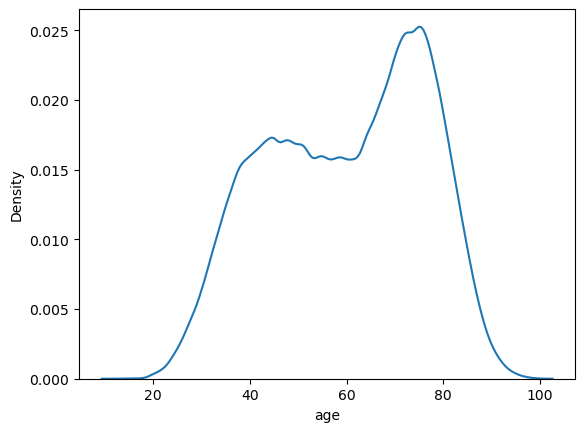

In [9]:
sns.kdeplot(data=df['age'], bw_adjust=0.5)
plt.show()

<AxesSubplot:>

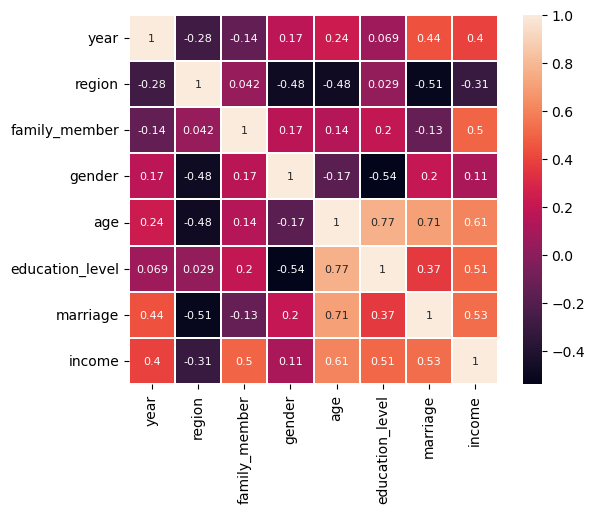

In [10]:
#20살 이하 (미성년자 계층)

corr = df[df['age']<20].corr()
sns.heatmap(corr, linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True, annot_kws = {'size':8})

<AxesSubplot:>

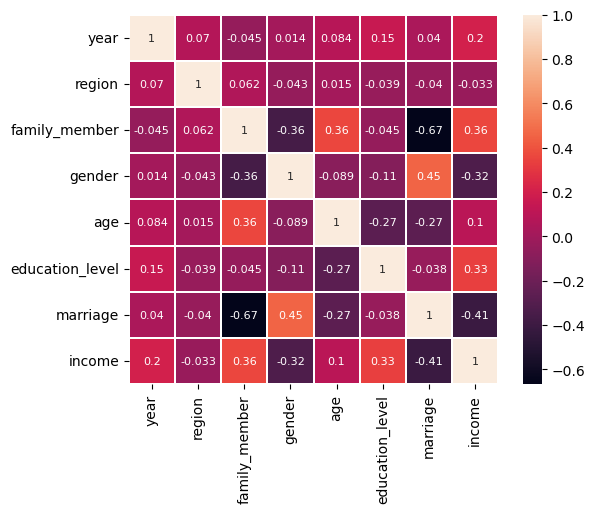

In [11]:
#생산인구 (20살 이상 50살 미만)

corr = df[(df['age']>=20) & (df['age']<=50)].corr()
sns.heatmap(corr, linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True, annot_kws = {'size':8})

<AxesSubplot:>

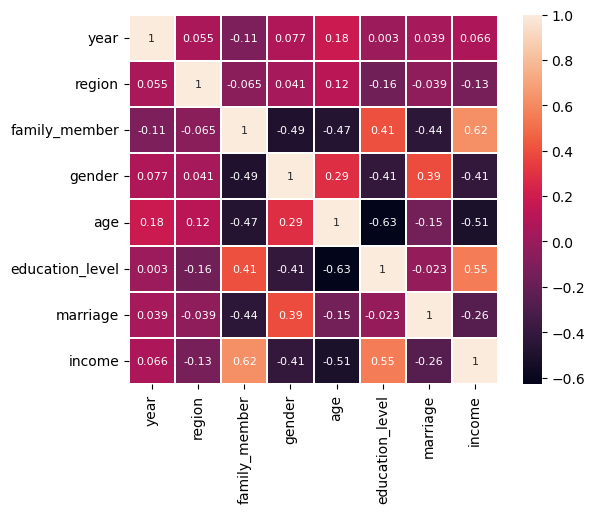

In [12]:
#50살 이상 (퇴직 계층)-평균 퇴직연령 약 50세

corr = df[df['age']>20].corr()
sns.heatmap(corr, linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True, annot_kws = {'size':8})

In [13]:
category_cols = [ col for col in list(df.columns) if df[col].dtype =='object']
category_cols.append('region')
category_cols.append('gender')
df = df.astype({'marriage' : 'object'})
category_cols.append('marriage')
category_cols

['occupation',
 'company_size',
 'reason_none_worker',
 'region',
 'gender',
 'marriage']

In [14]:
df['company_size'].unique()

array(['1', ' ', '3', '10', '9', '2', '7', '11', '4', '6', '8', '5', '99'],
      dtype=object)

### 숫자로 이루어진 column 정리

In [15]:
num_cols = ['year', 'family_member', 'age', 'education_level'] 

In [16]:
df[df['income']<0]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
46,2012,7,3,1,66,3,1,611,1,,-1930.283224
205,2006,2,2,1,62,3,1,941,3,,-287.531789
253,2012,5,4,1,48,5,1,151,1,,-1446.623094
793,2006,1,4,1,54,3,1,,,,-1576.872536
1339,2007,2,3,2,44,5,3,912,1,,-1264.487179
...,...,...,...,...,...,...,...,...,...,...,...
76352,2006,3,4,1,44,5,1,713,1,,-781.865966
77466,2007,6,2,1,61,3,1,611,1,,-535.897436
78003,2016,4,2,1,74,4,1,613,1,,-612.734864
78276,2010,4,2,1,67,5,1,611,1,,-54.398148


In [17]:
df.drop(index=df[df['income'] < 0].index, inplace=True)

# Region 

<AxesSubplot:xlabel='region', ylabel='count'>

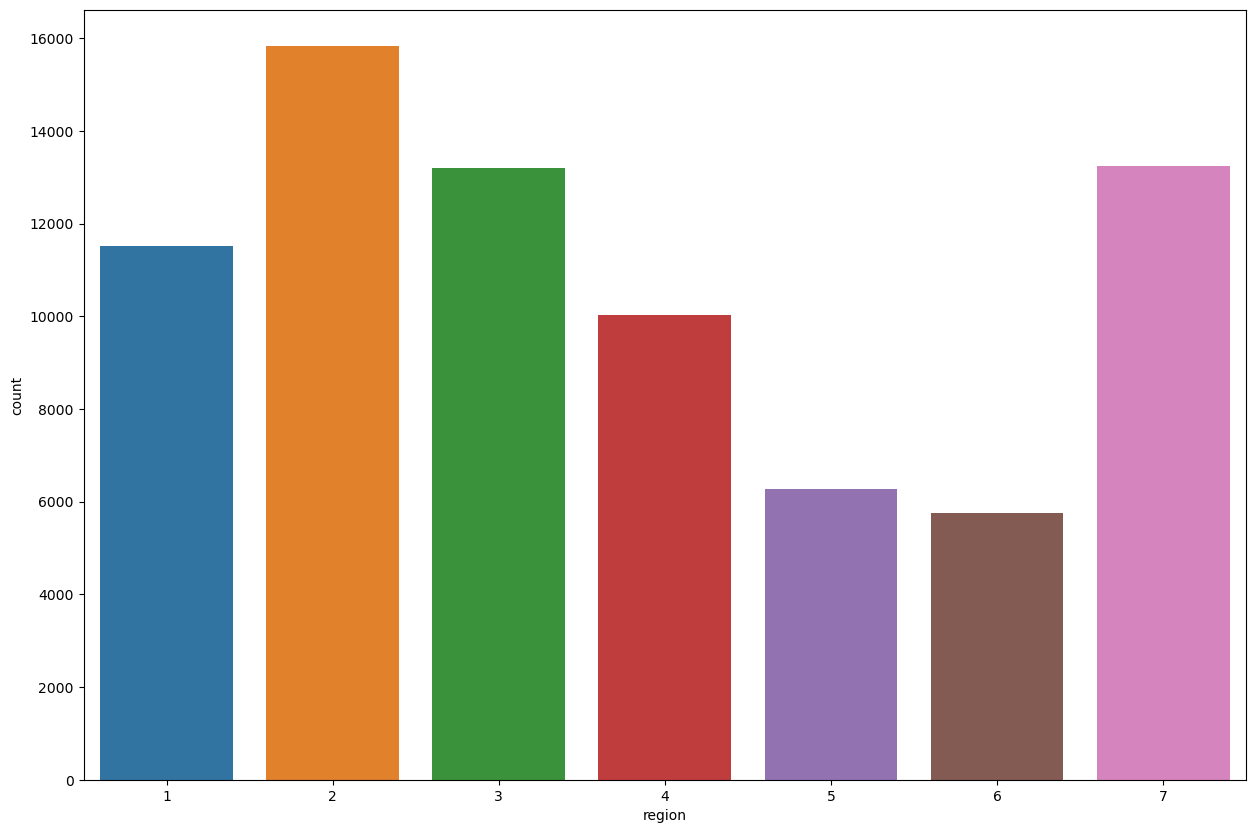

In [18]:
plt.figure(figsize=(15,10))
sns.countplot(data = df, x = category_cols[3])
#1)  Seoul  2)  Kyeong-gi  3)  Kyoung-nam  4)  Kyoung-buk  5)  Chung-nam  6)  Gang-won  & Chung-buk 7) Jeolla & Jeju

<AxesSubplot:xlabel='region', ylabel='income'>

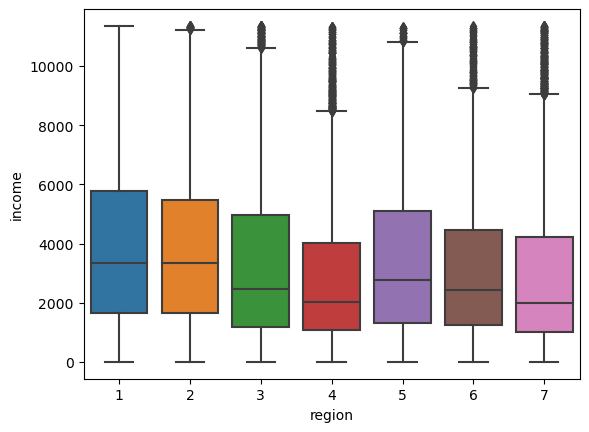

In [19]:
sns.boxplot(x='region', y='income', data=df)

<AxesSubplot:xlabel='region', ylabel='income'>

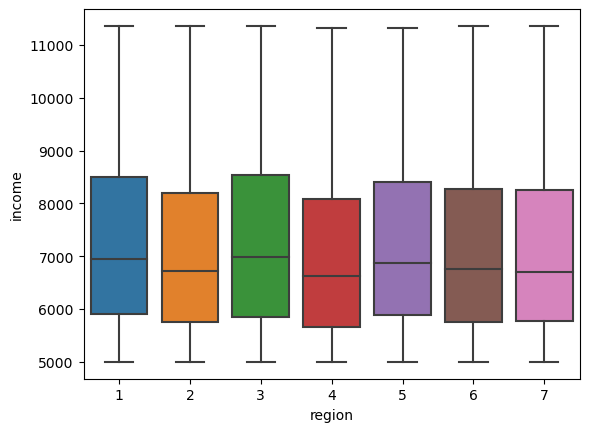

In [20]:
filtered_data = df[df["income"] >= 5000]
sns.boxplot(x='region', y='income', data=filtered_data)

## 수도권 / 지방권으로 나눔

<AxesSubplot:xlabel='region', ylabel='count'>

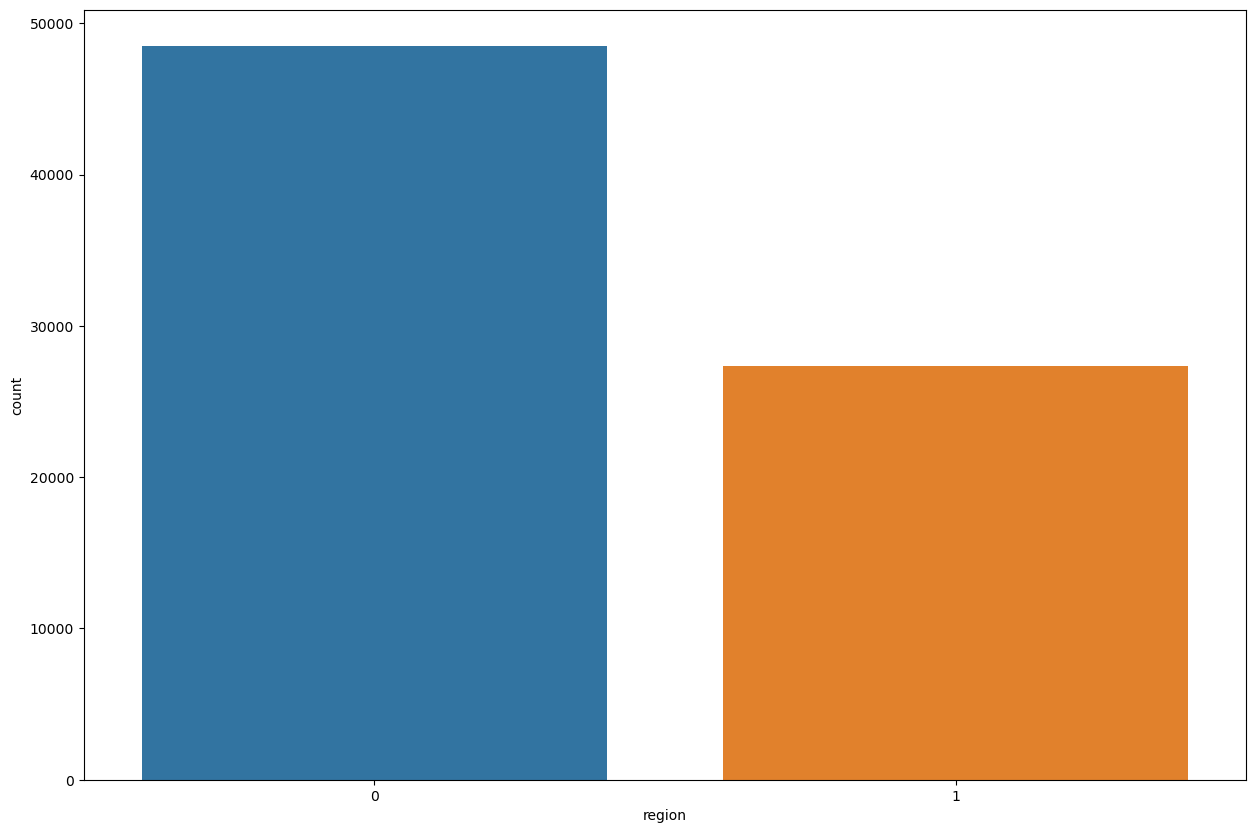

In [21]:
region1_df = df.copy()
region1_df['region'] = region1_df['region'].apply(lambda x: 1 if int(x) in [1,2] else 0)
plt.figure(figsize=(15,10))
sns.countplot(data = region1_df, x = category_cols[3])

<AxesSubplot:xlabel='region', ylabel='income'>

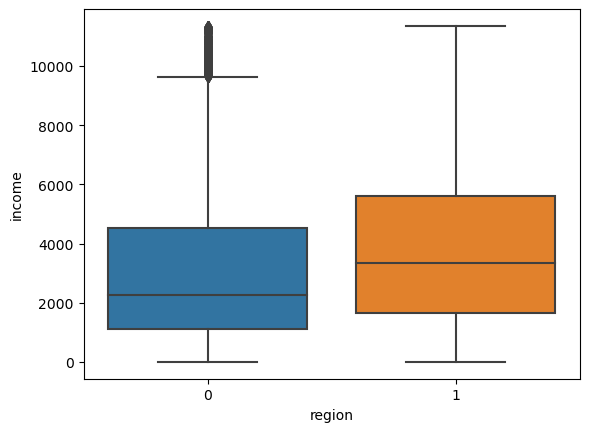

In [22]:
sns.boxplot(x='region', y='income', data=region1_df)

<AxesSubplot:>

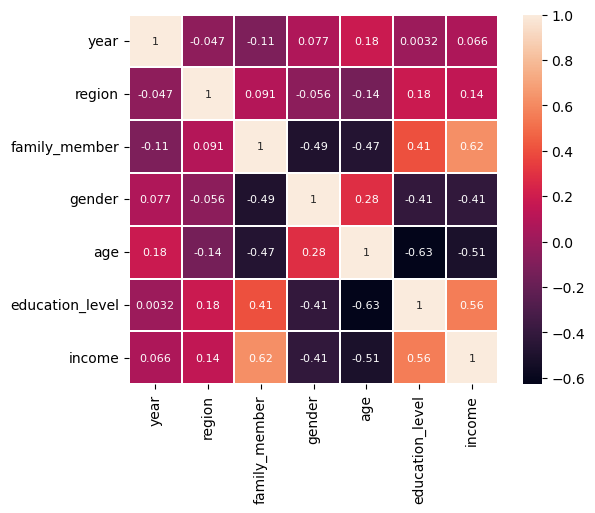

In [23]:
corr1 = region1_df.corr()
sns.heatmap(corr1, linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True, annot_kws = {'size':8})

## 서울 / 경기 / 지방으로 나눔

<AxesSubplot:xlabel='region', ylabel='count'>

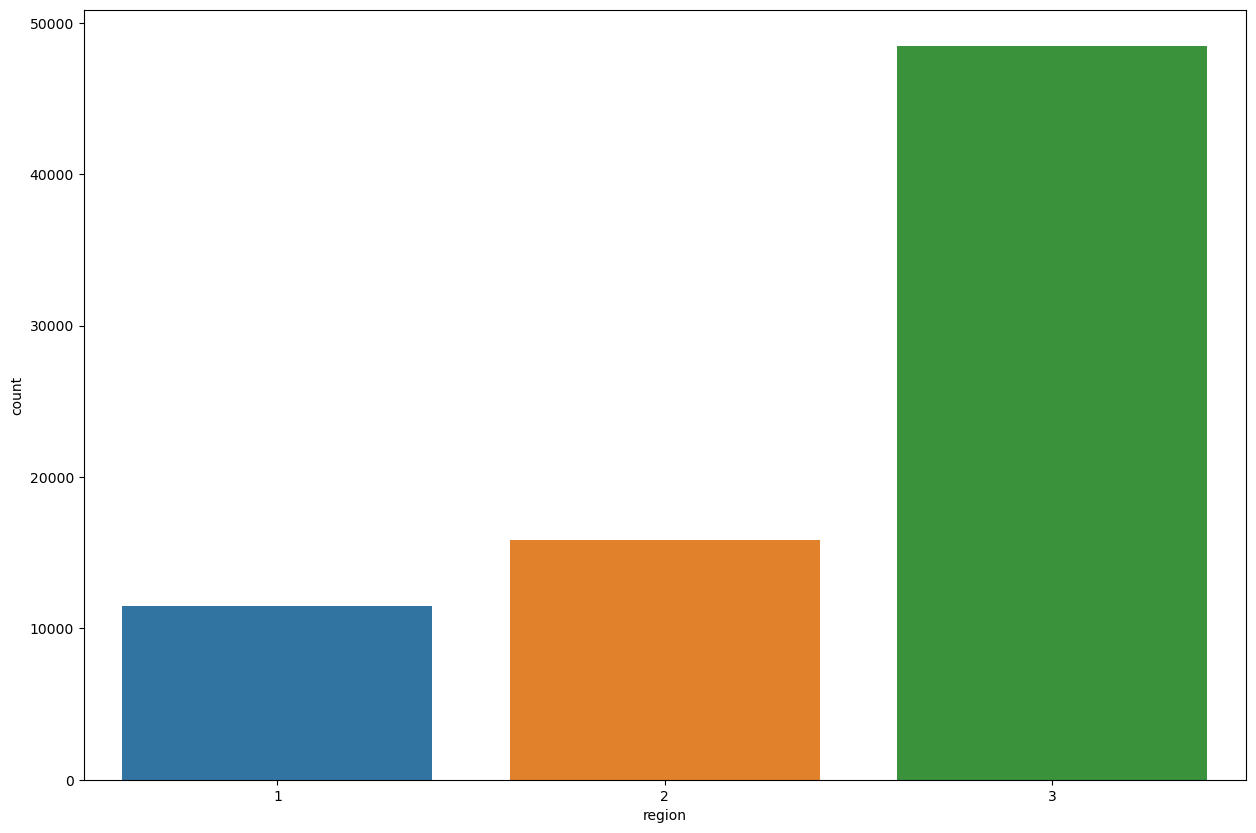

In [97]:
region2_df = df.copy()
region2_df['region'] = region2_df['region'].apply(lambda x: 3 if int(x) in [3,4,5,6,7] else x)
plt.figure(figsize=(15,10))
sns.countplot(data = region2_df, x = category_cols[3])

<AxesSubplot:xlabel='region', ylabel='income'>

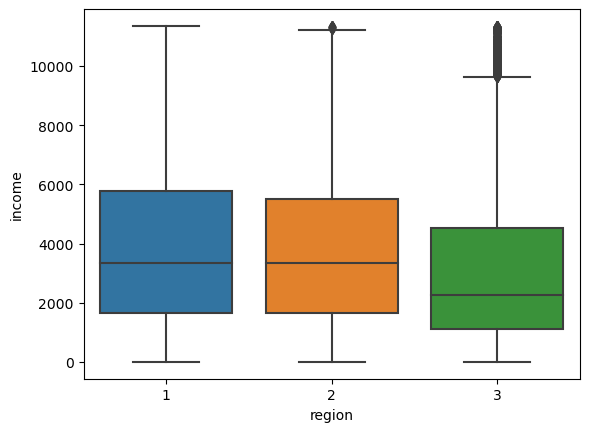

In [98]:
sns.boxplot(x='region', y='income', data=region2_df)

<AxesSubplot:>

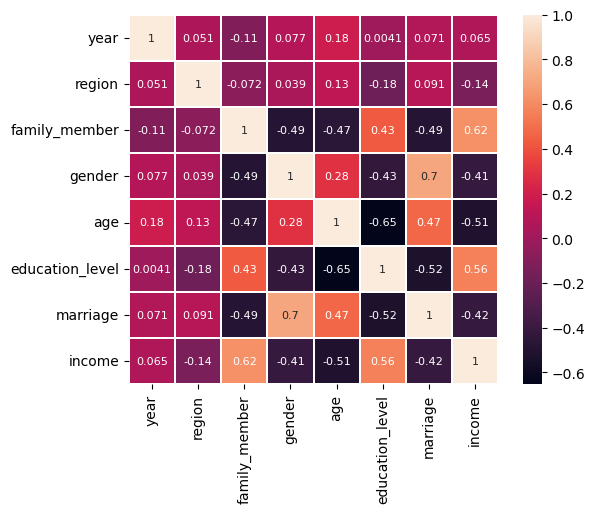

In [99]:
corr2 = region2_df.corr()
sns.heatmap(corr2, linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True, annot_kws = {'size':8})

# Marriage

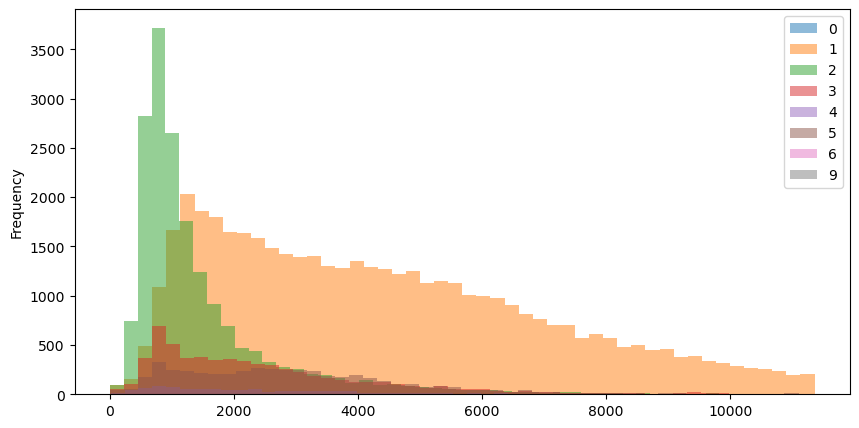

In [27]:
grouped = df.groupby('marriage')['income'].describe()

fig, ax = plt.subplots(figsize=(10, 5))
for idx, row in grouped.iterrows():
    df.loc[df['marriage']==idx, 'income'].plot(kind='hist', bins=50, alpha=0.5, ax=ax, label=idx)
ax.legend()
plt.show()

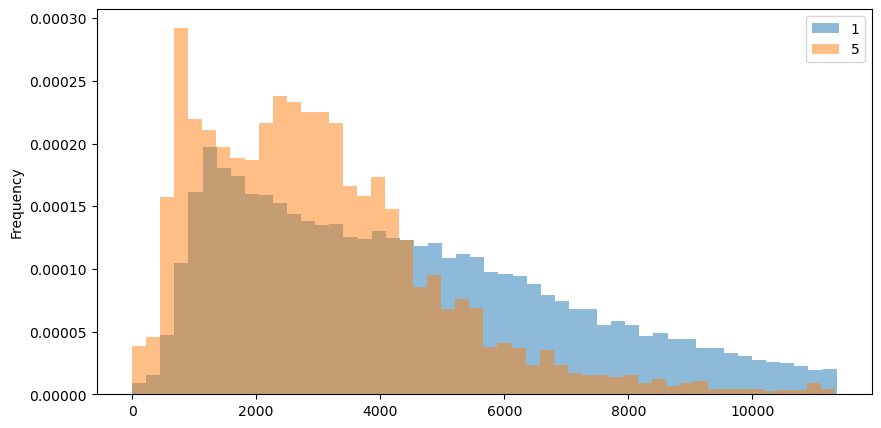

In [28]:
grouped = df[df['marriage'].isin([1,5])].groupby('marriage')['income'].describe()

fig, ax = plt.subplots(figsize=(10, 5))
for idx, row in grouped.iterrows():
    df.loc[df['marriage']==idx, 'income'].plot(kind='hist', bins=50, alpha=0.5, ax=ax, label=idx, density = True)
ax.legend()
plt.show()

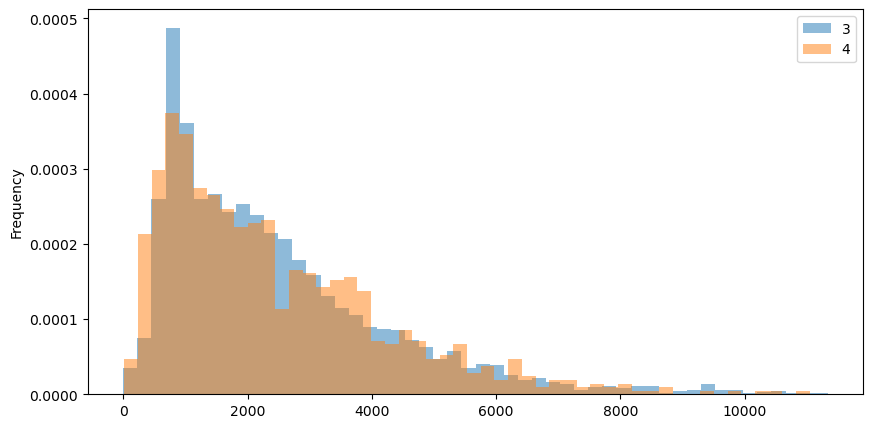

In [29]:
grouped = df[df['marriage'].isin([3,4])].groupby('marriage')['income'].describe()

fig, ax = plt.subplots(figsize=(10, 5))
for idx, row in grouped.iterrows():
    df.loc[df['marriage']==idx, 'income'].plot(kind='hist', bins=50, alpha=0.5, ax=ax, label=idx, density = True)
ax.legend()
plt.show()

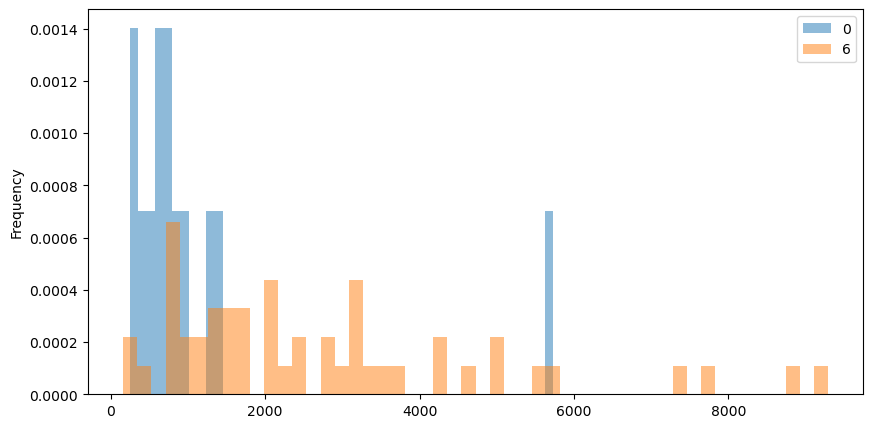

In [30]:
grouped = df[df['marriage'].isin([0,6])].groupby('marriage')['income'].describe()

fig, ax = plt.subplots(figsize=(10, 5))
for idx, row in grouped.iterrows():
    df.loc[df['marriage']==idx, 'income'].plot(kind='hist', bins=50, alpha=0.5, ax=ax, label=idx, density = True)
ax.legend()
plt.show()

In [31]:
df[df['marriage']==0]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
4782,2005,7,1,1,14,4,0,,,,248.655914
15459,2006,5,2,1,29,7,0,311,10,,5729.303548
18581,2006,7,2,1,18,5,0,,,3,1316.688568
19535,2005,7,2,1,17,5,0,,,3,1450.268817
25581,2009,7,1,1,18,5,0,,,10,610.250298
32549,2006,6,1,1,71,3,0,611,1,,588.699080
48236,2006,7,1,1,75,2,0,611,1,,746.386334
53535,2013,7,1,2,12,3,0,,,,270.967742
60433,2006,4,1,2,82,2,0,,,8,416.557162
62356,2007,7,1,1,16,5,0,,,8,933.333333


In [32]:
#marriage 0이랑 9는 날리고 2는 1로, 나머지는 0으로 

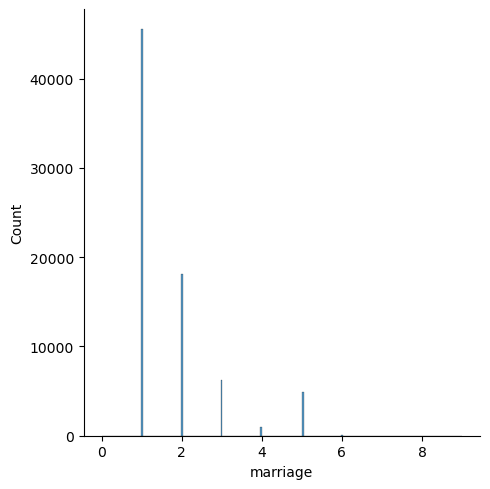

In [33]:
sns.displot(df['marriage']) #1~6

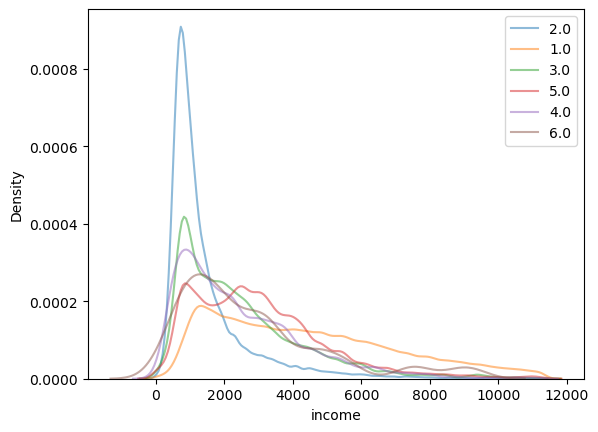

In [35]:
df['marriage'] = df['marriage'].replace({0:np.nan, 9:np.nan})

for i, reason in enumerate(df['marriage'].unique()):
    data = df[df['marriage'] == reason]
    sns.kdeplot(data=data['income'], bw_adjust=0.5, label=reason, alpha=0.5)
plt.legend()
plt.show()
#2 즉 배우자 있음만 특이하고 나머지는 비슷한듯.

In [36]:
#others가 6개....배우자가 있다 / 없다로 분류한다면, 없다에 넣어도 되지 않을까? 
#배우자 없음을 0, 있음을 1로 하자.

df['marriage'] = df['marriage'].replace({1:0, 3:0, 4:0, 5:0, 2:1})
df['marriage'].value_counts()

0.0    57659
1.0    18097
6.0       50
Name: marriage, dtype: int64

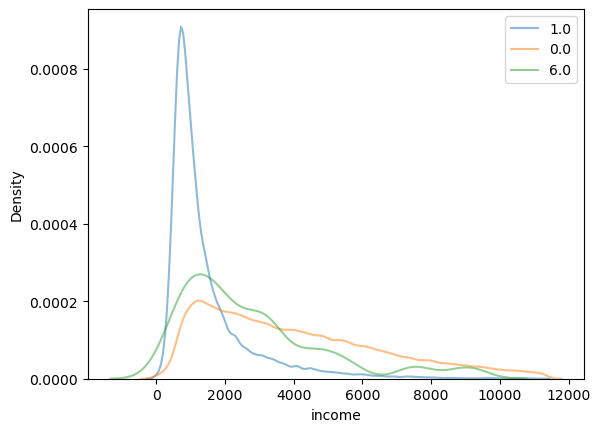

In [37]:
for i, reason in enumerate(df['marriage'].unique()):
    data = df[df['marriage'] == reason]
    sns.kdeplot(data=data['income'], bw_adjust=0.5, label=reason, alpha=0.5)
plt.legend()
plt.show()

#배우자 없음(=0)과 others(=6)이 좀 비슷해보이지 않나...? 

0.0    57709
1.0    18097
Name: marriage, dtype: int64


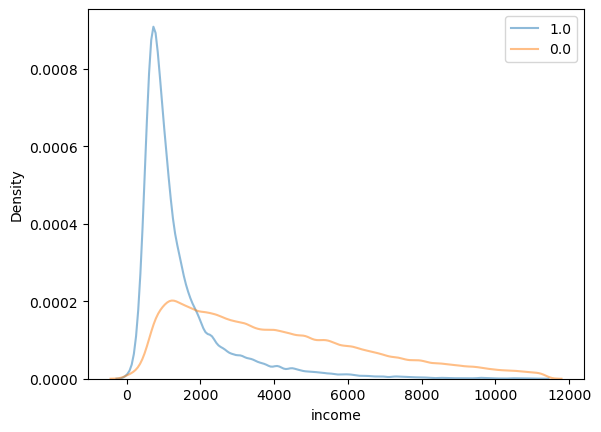

In [38]:
#6을 걍 0에 넣읍시다!
df['marriage'].replace(6, 0, inplace=True)
print(df['marriage'].value_counts())

for i, reason in enumerate(df['marriage'].unique()):
    data = df[df['marriage'] == reason]
    sns.kdeplot(data=data['income'], bw_adjust=0.5, label=reason, alpha=0.5)
plt.legend()
plt.show()
#사실 그래프는 어디넣든 별 차이 없는게 맞음. others의 개수가 작기 때문.

## Family member

In [39]:
#df['family_member'].isnull().sum() #null값 없음.
df['family_member'].unique() #1~9...근데 가족 수가 9명
#개수확인해보자.
df['family_member'].value_counts()

2    24032
1    21324
4    12950
3    12841
5     3681
6      812
7      163
8       16
9        7
Name: family_member, dtype: int64

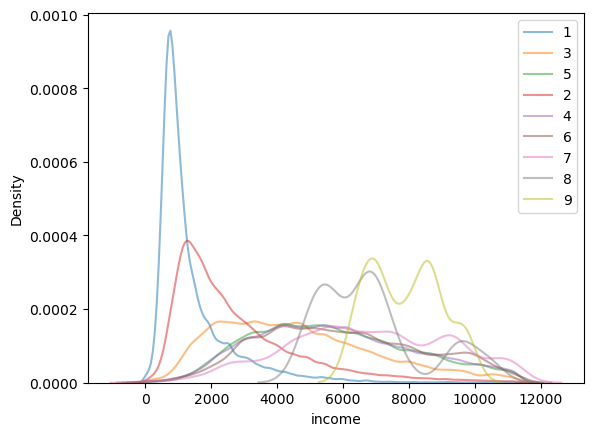

In [40]:
for i, reason in enumerate(df['family_member'].unique()):
    data = df[df['family_member'] == reason]
    sns.kdeplot(data=data['income'], bw_adjust=0.5, label=reason, alpha=0.5)
plt.legend()
plt.show()
#3~7이 분포가 비슷하네.

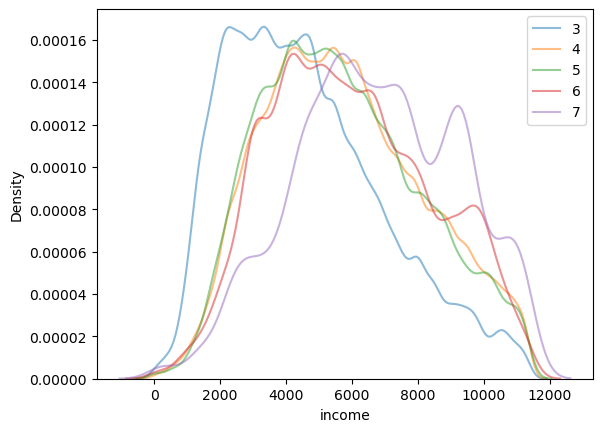

In [41]:
#3~7만 출력하면 이런느낌
for reason in [3,4,5,6,7]:
    data = df[df['family_member'] == reason]
    sns.kdeplot(data=data['income'], bw_adjust=0.5, label=reason, alpha=0.5)
plt.legend()
plt.show()


<AxesSubplot:xlabel='family_member', ylabel='income'>

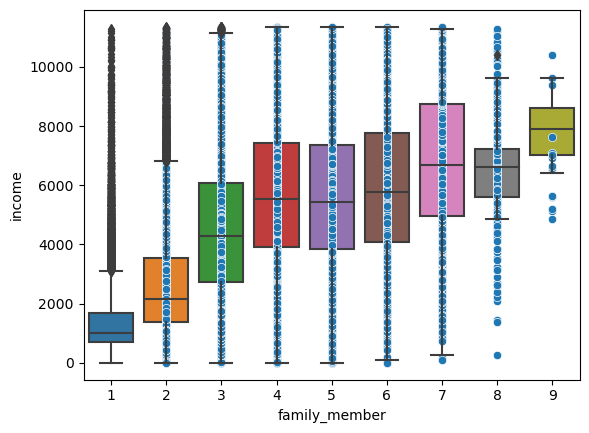

In [42]:
sns.scatterplot(x='family_member', y='income', data=df)
sns.boxplot(x='family_member', y='income', data=df)

## Occupation 분류 정리
### occupation의 경우 분류가 너무 세분화하여 대분류로 구조화하여 처리함
다른 직업코드 자료 확인시 가장 첫번째 자리 - 대분류, 다음 자리 - 소분류 등으로 구조화되어 있어 있음

In [43]:
df[df['occupation']=='9999'] ##버려???? 버려!
df.drop(index=df[df['occupation'] == '9999'].index, inplace=True)

# occupation 대분류로 바꾸기

In [44]:
df['occupation'] = df['occupation'].str[0]

In [45]:
df['occupation'].unique()

array(['6', ' ', '5', '9', '2', '8', '4', '7', '3', '1'], dtype=object)

# education level

In [46]:
df['education_level'].unique()

array([2, 5, 6, 3, 4, 7, 8, 9])

In [47]:
df['education_level'].unique()

array([2, 5, 6, 3, 4, 7, 8, 9])

<AxesSubplot:xlabel='education_level', ylabel='income'>

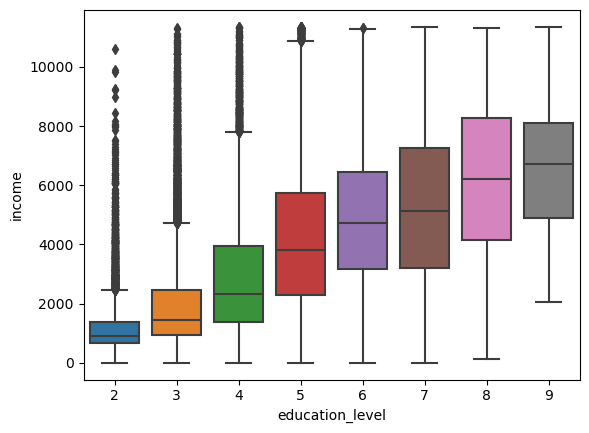

In [48]:
sns.boxplot(x='education_level', y='income', data=df)

In [49]:
print(df[df['education_level']==6].income.mean(), df[df['education_level']==6].income.std())

4915.758690702139 2358.0885680291826


In [50]:
print(df[df['education_level']==7].income.mean(), df[df['education_level']==7].income.std())

5330.38284940544 2701.572727435581


In [51]:
df['education_level'] = df['education_level'].replace({7:6})

<AxesSubplot:xlabel='education_level', ylabel='income'>

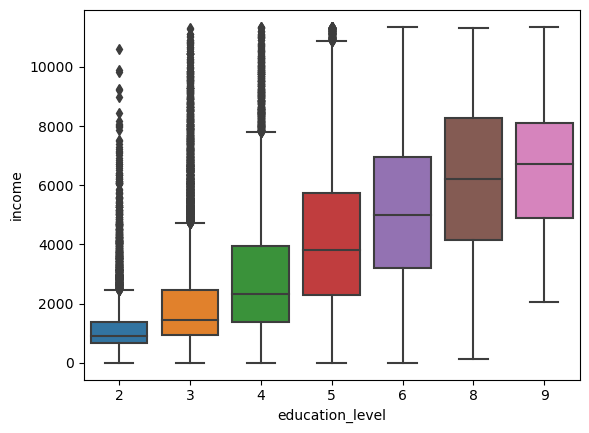

In [52]:
sns.boxplot(x='education_level', y='income', data=df)

In [53]:
df['education_level'] = df['education_level'].replace({2: 1, 3: 2, 4: 3, 5: 4, 6:5, 8:6, 9:7})

<AxesSubplot:xlabel='education_level', ylabel='income'>

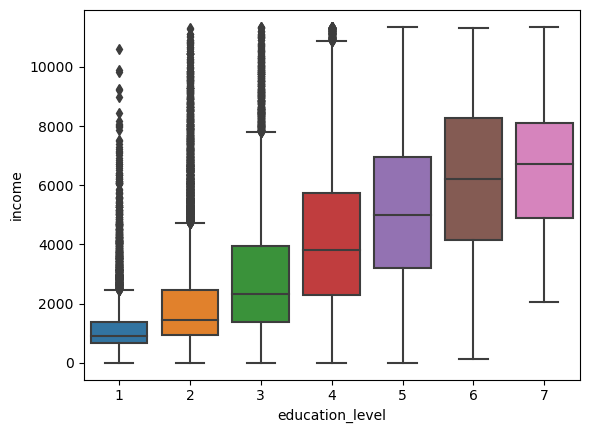

In [54]:
sns.boxplot(x='education_level', y='income', data=df)

In [55]:
q1 = df[df['education_level'] == 1]['income'].quantile(0.25)
q3 = df[df['education_level'] == 1]['income'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

df_edu = df[(df['education_level'] == 1) & (df['income'] > upper_bound)]
df_edu

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
28,2013,5,5,1,78,1,0.0,6,1,,3573.118280
67,2008,3,2,1,60,1,0.0,6,1,,2997.552020
115,2005,7,2,1,63,1,0.0,6,1,,3481.182796
222,2010,7,1,2,75,1,1.0,,,10,2645.833333
716,2009,2,2,1,76,1,0.0,,,8,2884.386174
...,...,...,...,...,...,...,...,...,...,...,...
78331,2008,4,3,1,62,1,0.0,9,2,,3004.895961
78428,2017,3,2,1,89,1,0.0,,,10,2513.319672
78560,2010,7,2,1,68,1,0.0,,,10,2703.703704
78922,2016,4,1,2,83,1,1.0,,,1,3124.217119


In [56]:
df_edu[~df_edu['occupation'].isnull()]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
28,2013,5,5,1,78,1,0.0,6,1,,3573.118280
67,2008,3,2,1,60,1,0.0,6,1,,2997.552020
115,2005,7,2,1,63,1,0.0,6,1,,3481.182796
222,2010,7,1,2,75,1,1.0,,,10,2645.833333
716,2009,2,2,1,76,1,0.0,,,8,2884.386174
...,...,...,...,...,...,...,...,...,...,...,...
78331,2008,4,3,1,62,1,0.0,9,2,,3004.895961
78428,2017,3,2,1,89,1,0.0,,,10,2513.319672
78560,2010,7,2,1,68,1,0.0,,,10,2703.703704
78922,2016,4,1,2,83,1,1.0,,,1,3124.217119


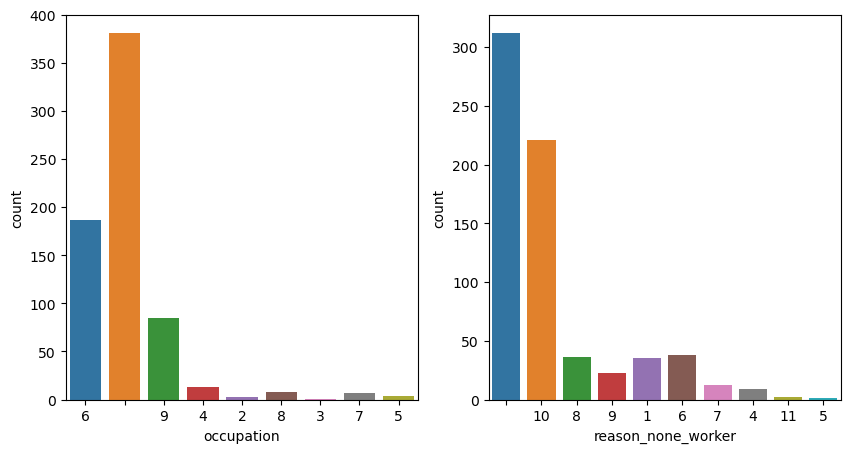

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.countplot(data=df_edu, x=category_cols[0], ax=ax[0])
sns.countplot(data=df_edu, x=category_cols[2], ax=ax[1])

plt.show()

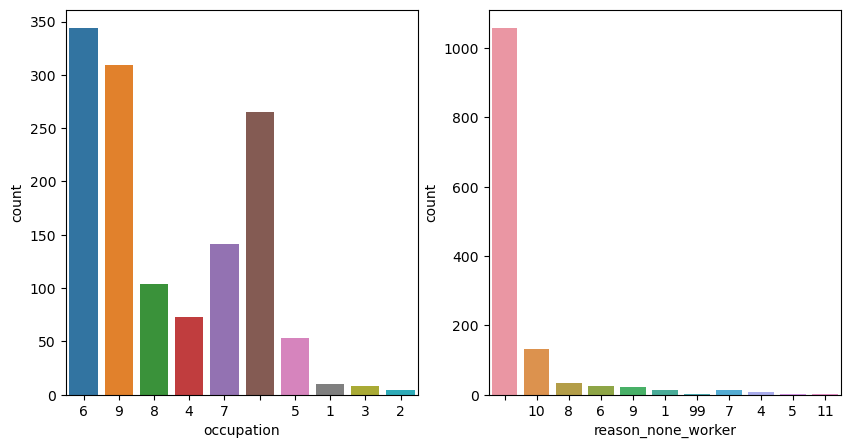

In [58]:
q1 = df[df['education_level'] == 2]['income'].quantile(0.25)
q3 = df[df['education_level'] == 2]['income'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

df_edu2 = df[(df['education_level'] == 2) & (df['income'] > upper_bound)]
df_edu2
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.countplot(data=df_edu2, x=category_cols[0], ax=ax[0])
sns.countplot(data=df_edu2, x=category_cols[2], ax=ax[1])

plt.show()

In [59]:
df_edu3 = df[(df['education_level'] == 3) & (df['income'] > upper_bound)]

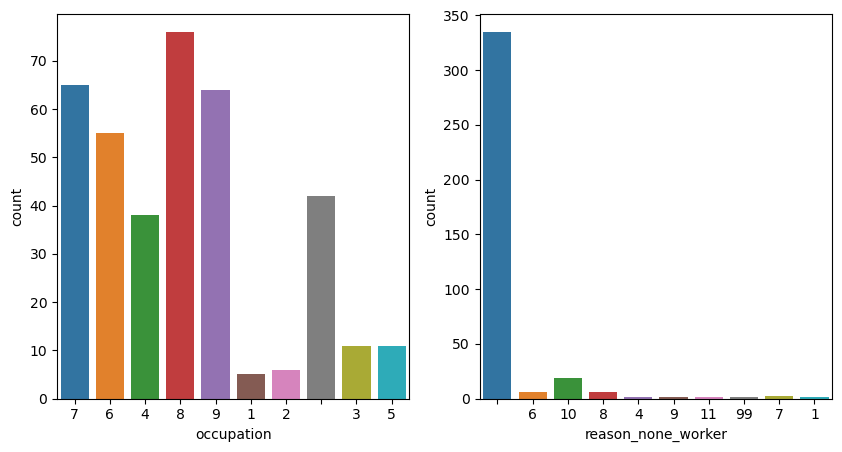

In [60]:
q1 = df[df['education_level'] == 3]['income'].quantile(0.25)
q3 = df[df['education_level'] == 3]['income'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
df_edu3 = df[(df['education_level'] == 3) & (df['income'] > upper_bound)]
df_edu3
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.countplot(data=df_edu3, x=category_cols[0], ax=ax[0])
sns.countplot(data=df_edu3, x=category_cols[2], ax=ax[1])

plt.show()

### 공백을 결측치 값으로 대체 
#### 컬럼별 결측치 합 파악

In [61]:
df.replace(' ', np.nan, inplace=True)

In [62]:
df.isnull().sum()

year                      0
region                    0
family_member             0
gender                    0
age                       0
education_level           0
marriage                 20
occupation            28492
company_size          28491
reason_none_worker    48558
income                    0
dtype: int64

## 무직자의 이유 중 비정상적인 값이 존재

In [63]:
df[(df['reason_none_worker']=='0') & (df['occupation'].isnull())]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
45540,2008,7,4,1,35,5,0.0,NaN,NaN,0,5192.166463


In [64]:
df[df['reason_none_worker']=='0']

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
45540,2008,7,4,1,35,5,0.0,NaN,NaN,0,5192.166463


In [65]:
df[(df['reason_none_worker']=='99') & (df['occupation'].isnull())]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
3500,2007,6,3,1,73,2,0.0,NaN,NaN,99,4724.358974
5681,2007,2,3,1,56,2,0.0,NaN,NaN,99,2057.692308
5912,2005,2,3,1,32,5,0.0,NaN,NaN,99,932.795699
7027,2005,1,1,2,48,2,0.0,NaN,NaN,99,967.741935
7081,2007,2,2,2,69,2,0.0,NaN,NaN,99,1050.000000
...,...,...,...,...,...,...,...,...,...,...,...
73828,2006,1,3,2,62,3,0.0,NaN,NaN,99,867.279895
75624,2005,5,1,2,64,1,1.0,NaN,NaN,99,642.473118
75858,2005,7,3,1,61,3,0.0,NaN,NaN,99,724.462366
75907,2005,2,1,2,71,1,1.0,NaN,NaN,99,1147.849462


In [66]:
df[(df['reason_none_worker']=='99')]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
3500,2007,6,3,1,73,2,0.0,NaN,NaN,99,4724.358974
5681,2007,2,3,1,56,2,0.0,NaN,NaN,99,2057.692308
5912,2005,2,3,1,32,5,0.0,NaN,NaN,99,932.795699
7027,2005,1,1,2,48,2,0.0,NaN,NaN,99,967.741935
7081,2007,2,2,2,69,2,0.0,NaN,NaN,99,1050.000000
...,...,...,...,...,...,...,...,...,...,...,...
73828,2006,1,3,2,62,3,0.0,NaN,NaN,99,867.279895
75624,2005,5,1,2,64,1,1.0,NaN,NaN,99,642.473118
75858,2005,7,3,1,61,3,0.0,NaN,NaN,99,724.462366
75907,2005,2,1,2,71,1,1.0,NaN,NaN,99,1147.849462


## reason_none_worker 전처리 및 분포 확인
* 0과 99의 경우 others인 11로 이동시킴. 

In [67]:
df.drop(index=df[df['reason_none_worker'] == "99"].index, inplace=True) #그냥 지움
df.loc[df['reason_none_worker'] == "0", 'reason_none_worker'] = "11" #이유가 0인 것 other로 이동
for i in ["0","1","2","3","4","5","6","7","8","9","10","11","99"]:
    print(i,len(df.loc[df['reason_none_worker']==i]))

0 0
1 2134
2 7
3 45
4 607
5 283
6 915
7 955
8 3619
9 2281
10 16150
11 196
99 0


#### occupation과 reason_non_worker 둘다 결측치를 가지고 있는 경우

In [68]:
df[df['occupation'].isnull() & df['reason_none_worker'].isnull()]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
6,2005,2,2,1,66,4,0.0,NaN,NaN,NaN,2469.086022
8,2016,3,3,1,50,5,0.0,NaN,NaN,NaN,1638.830898
37,2017,3,2,1,56,3,0.0,NaN,NaN,NaN,2080.942623
150,2015,1,4,1,50,5,0.0,NaN,NaN,NaN,1826.132771
179,2005,3,3,1,59,4,0.0,NaN,NaN,NaN,2588.709677
...,...,...,...,...,...,...,...,...,...,...,...
78765,2011,1,1,1,54,2,0.0,NaN,NaN,NaN,461.624027
78784,2014,1,2,1,47,4,0.0,NaN,NaN,NaN,1002.123142
78847,2007,2,3,1,41,4,0.0,NaN,NaN,NaN,5747.435897
78873,2014,2,4,1,50,3,0.0,NaN,NaN,NaN,4384.288747


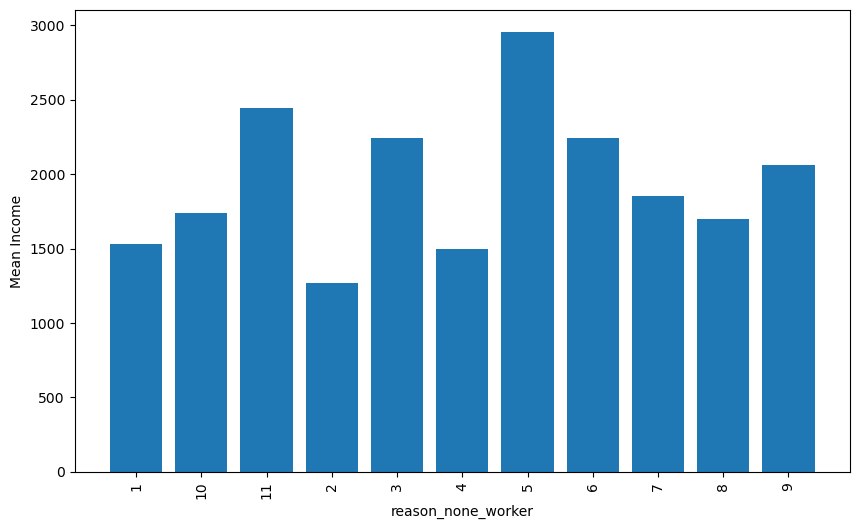

In [69]:
reason_none_worker_mean = df.groupby('reason_none_worker')['income'].mean()
reason_none_worker_count = df['reason_none_worker'].value_counts().sort_values(ascending=True)
key_func = lambda x: int(x) if str(x).isnumeric() else x
reason_none_worker_mean = reason_none_worker_mean.loc[reason_none_worker_count.index].sort_index(key=key_func)

plt.figure(figsize=(10,6))
plt.bar(reason_none_worker_mean.index, reason_none_worker_mean.values)
plt.xticks(rotation=90)
plt.xlabel('reason_none_worker')
plt.ylabel('Mean Income')
plt.show()

### reason_none_worker과 income 관계확인

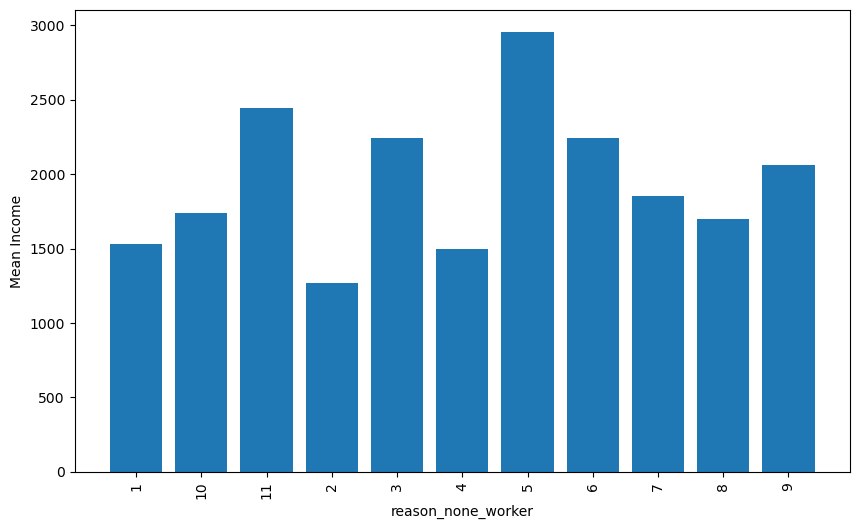

In [70]:
reason_none_worker_mean = df.groupby('reason_none_worker')['income'].mean()
reason_none_worker_count = df['reason_none_worker'].value_counts().sort_values(ascending=True)
key_func = lambda x: int(x) if str(x).isnumeric() else x
reason_none_worker_mean = reason_none_worker_mean.loc[reason_none_worker_count.index].sort_index(key=key_func)

plt.figure(figsize=(10,6))
plt.bar(reason_none_worker_mean.index, reason_none_worker_mean.values)
plt.xticks(rotation=90)
plt.xlabel('reason_none_worker')
plt.ylabel('Mean Income')
plt.show()

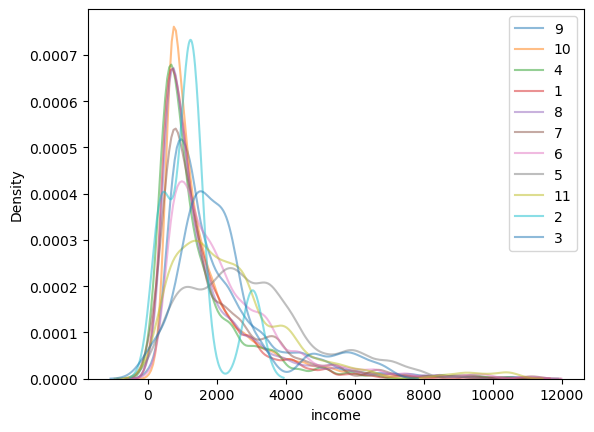

In [71]:
for i, reason in enumerate(df['reason_none_worker'].unique()):
    data = df[df['reason_none_worker'] == reason]
    sns.kdeplot(data=data['income'], bw_adjust=0.5, label=reason, alpha=0.5)
plt.legend()
plt.show()

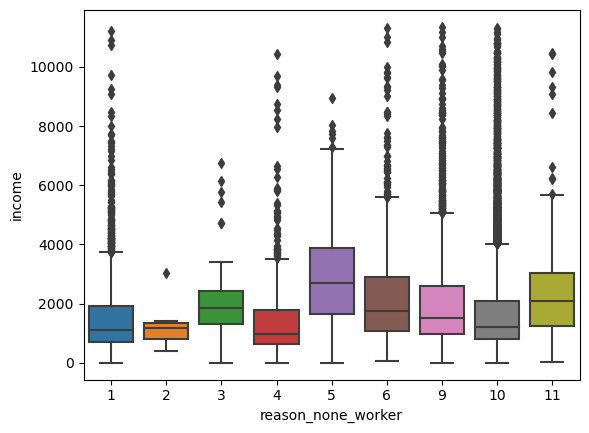

In [72]:
data1 = df[df['reason_none_worker'] == '1']
data2 = df[df['reason_none_worker'] == '2']
data3 = df[df['reason_none_worker'] == '3']
data4 = df[df['reason_none_worker'] == '4']
data5 = df[df['reason_none_worker'] == '5']
data6 = df[df['reason_none_worker'] == '6']
data9 = df[df['reason_none_worker'] == '9']
data10 = df[df['reason_none_worker'] == '10']
data11 = df[df['reason_none_worker'] == '11']
sns.boxplot(x='reason_none_worker', y='income', data=pd.concat([data1, data2, data3, data4, data5, data6, data9, data10, data11]))
plt.show()

## 재직자/무직자로 분류하여 판단 진행 
* 여러 분포가 존재하기 때문에 좀 더 정확한 모델 구축과 데이터 파악을 위해 분류하여 판단하기로 결정
### 이상 데이터 존재
재직자, 무직자 데이터가 둘다 존재하거나, 둘다 존재하지 않거나, 무직자임에도 수입이 있는 경우 존재 -> 데이터 전처리 방식 고민
#### occupation과 reason_non_worker 둘다 결측값을 가지고 있는 경우
결측치, 비정상 값을 가지고 있는 값들을 어떠한 처리를 할지 고려하기 위한 작업
* 재직자/실업자임이 판단이 불가능함에도 소득이 존재한다면 재직자의 분류로 나눠야할 필요가 있을지 고민
* 다만 데이터 자체가 잘못됐음을 고려해야하기 때문에 실업자의 수입보다 더 작은 직업 유무를 알 수 없는 데이터의 경우 분석할 데이터에 포함하지 않을지 고민

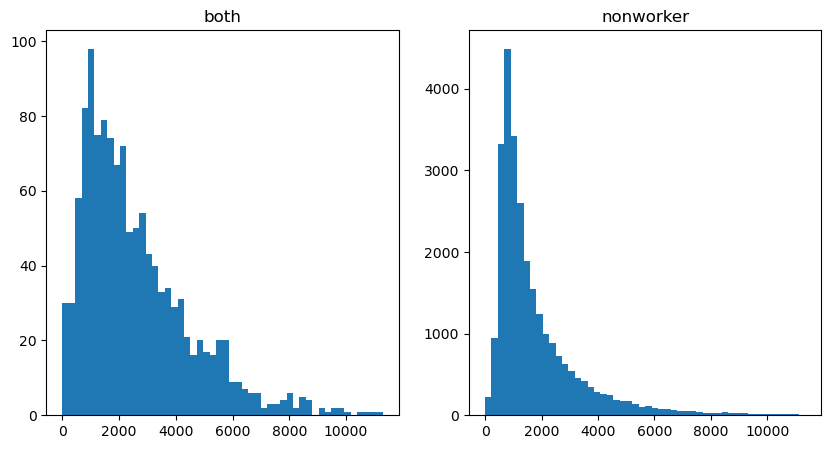

In [73]:
import matplotlib.pyplot as plt

both = df[(df['occupation'].isna()) & (df['reason_none_worker'].isna())]
non_worker = df[(df['occupation'].isna()) & (~df['reason_none_worker'].isna())]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(both['income'], bins=50)
ax[0].set_title('both')

ax[1].hist(non_worker['income'], bins=50)
ax[1].set_title('nonworker')

plt.show()

In [74]:
both[both['income']<non_worker['income'].mean()]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
8,2016,3,3,1,50,5,0.0,NaN,NaN,NaN,1638.830898
387,2013,1,2,1,69,2,0.0,NaN,NaN,NaN,1224.731183
453,2005,1,3,1,63,4,0.0,NaN,NaN,NaN,1362.903226
677,2008,3,1,2,45,3,1.0,NaN,NaN,NaN,498.164015
704,2007,3,2,1,56,3,0.0,NaN,NaN,NaN,617.948718
...,...,...,...,...,...,...,...,...,...,...,...
78380,2018,3,1,1,62,2,0.0,NaN,NaN,NaN,912.209889
78459,2016,6,1,1,48,4,0.0,NaN,NaN,NaN,779.749478
78730,2005,1,1,1,46,4,0.0,NaN,NaN,NaN,674.731183
78765,2011,1,1,1,54,2,0.0,NaN,NaN,NaN,461.624027


### 재직자/무직자 분류 확인
* 재직자 - occupation이 존재 (직업 존재), reason_none_worker(무직자인 이유 없음)
* 무직자 - occupation이 없음 (직업 없음), reason_none_worker(무직자인 이유)

In [75]:
no_dontcare = df[df['occupation'].isnull()] #직업이 결측치인 경우
yes_dontcare = df[~df['occupation'].isnull()] #직업이 정상적인 경우
nono = no_dontcare[no_dontcare['reason_none_worker'].isnull()] #무직자, 미취업 이유가 결측치
noyes = no_dontcare[~no_dontcare['reason_none_worker'].isnull()] #무직자, 미취업 이유 정상
yesno = yes_dontcare[yes_dontcare['reason_none_worker'].isnull()] #직업이 정상, 미취업 이유 결측치
yesyes = yes_dontcare[~yes_dontcare['reason_none_worker'].isnull()] #직업이 정상, 미취업 이유 정상

print("전체 데이터 수:",len(df))
print("둘다 데이터 없을 때:",len(nono), "무직자 수:", len(noyes),"재직자 수:", len(yesno), "둘다 데이터 있을 때:", len(yesyes))

worker = yesno
non_worker = noyes

print("\n재직자 수 / 무직자 수")
print(len(worker), len(non_worker))

전체 데이터 수: 75750
둘다 데이터 없을 때: 1236 무직자 수: 27192 재직자 수: 47322 둘다 데이터 있을 때: 0

재직자 수 / 무직자 수
47322 27192


#### -> 비정상적인 값이 존재하는 데이터의 경우 일단 배제하고 진행하기로 결정 (무직자, 미취업 이유가 둘다 존재하지 않을 경우)

### 직업이 존재하지 않는데  회사의 크기가 존재하는 경우
* 회사의 크기가 잘못된 데이터라 판단, 무직자의 데이터로 분류해줌
* company size를 nan으로 set

In [76]:
df[df['occupation'].isnull() & ~df['company_size'].isnull()]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
71475,2005,1,2,1,64,1,0.0,NaN,99,9,806.451613


In [77]:
df.loc[df['occupation'].isnull() & ~df['company_size'].isnull(), 'company_size'] = float('NaN')
df[df['company_size']=='99']

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,reason_none_worker,income
9016,2008,1,5,1,39,4,0.0,7,99,NaN,3949.816401
20258,2005,2,4,1,43,3,0.0,8,99,NaN,4926.075269
22211,2005,1,2,1,38,4,0.0,8,99,NaN,7123.655914
28184,2005,2,4,1,62,1,0.0,6,99,NaN,8024.193548
49329,2005,6,2,1,29,5,0.0,3,99,NaN,7467.741935
68256,2005,1,4,1,41,5,0.0,8,99,NaN,4897.849462


## 결측치 고려하여 필요한 행만 처리 
#### 위에서 한 것과 마찬가지로
#### * 재직자 데이터 : occupation이 결측치가 아니고 reason_none_worker가 결측치 인 행
* id와 wave는 추후 가설을 검증하고 결과를 얻는데에 불필요할 것이라 판단하여 제거하고 진행

#### * 무직자 데이터 :  reason_none_worker가 결측치가 아니고 occupation이 결측치 인 행
* 무직자의 경우 직업, company_size, id, wave가 불필요할 것이라 판단하여 제거하고 진행

In [78]:
df_w = df[(~df['occupation'].isna()) & (df['reason_none_worker'].isna())]
del df_w['reason_none_worker']

df_n = df[(df['occupation'].isna()) & (~df['reason_none_worker'].isna())]
del df_n['occupation']
del df_n['company_size']

## 재직자/무직자 데이터 전처리

In [79]:
df_w

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,income
0,2005,3,1,2,66,1,1.0,6,1,618.279570
2,2012,2,3,1,46,5,0.0,5,1,3108.932462
3,2011,4,5,1,65,2,0.0,6,1,4771.968854
5,2007,3,3,1,71,3,0.0,9,3,1925.641026
7,2015,3,4,1,41,5,0.0,2,10,8909.378293
...,...,...,...,...,...,...,...,...,...,...
78920,2005,2,5,1,36,4,0.0,9,1,2096.774194
78921,2018,4,2,1,70,3,0.0,6,1,3757.820383
78923,2007,2,4,1,43,4,0.0,9,5,7512.820513
78924,2006,2,4,1,35,4,0.0,5,2,4919.842313


# 재직자 데이터 중 company size 이상치 처리
* 버리기

In [80]:
throw_index = df_w[df_w['company_size']=='99'].index
df_w = df_w.drop(throw_index)
df_w['company_size'].unique()

array(['1', '3', '10', '9', '2', '7', '11', '4', '6', '8', '5'],
      dtype=object)

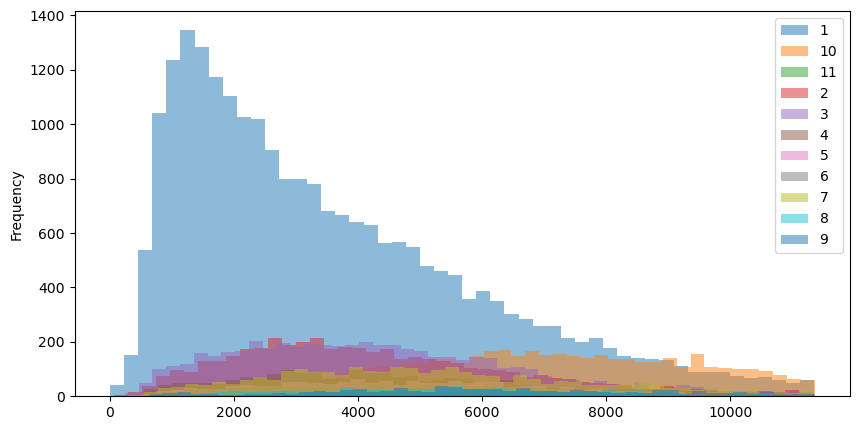

In [81]:
grouped = df_w.groupby('company_size')['income'].describe()

# 히스토그램 그리기
fig, ax = plt.subplots(figsize=(10, 5))
for idx, row in grouped.iterrows():
    df.loc[df['company_size']==idx, 'income'].plot(kind='hist', bins=50, alpha=0.5, ax=ax, label=idx)
ax.legend()
plt.show()

### Categorical Indexing 진행 중
* 더미변수로 변환하여 새로운 데이터프레임(df_w_dum, df_n_dum)을 생성
* 위의 생성된 데이터프레임과 num_cols 변수로 지정된 수치형 데이터 열들을 합쳐서 새로운 데이터프레임 data_w, data_n 생성

In [82]:
df_w.columns

Index(['year', 'region', 'family_member', 'gender', 'age', 'education_level',
       'marriage', 'occupation', 'company_size', 'income'],
      dtype='object')

In [83]:
w_category = ['region', 'marriage', 'occupation']
df_w['company_size'] = pd.to_numeric(df_w['company_size'], errors='coerce')
w_num=['family_member', 'age', 'education_level', 'company_size']

n_category = ['region', 'marriage', 'reason_none_worker']
n_num=['family_member', 'age', 'education_level']

In [84]:
df_w['company_size'].unique()

array([ 1,  3, 10,  9,  2,  7, 11,  4,  6,  8,  5])

In [85]:
df_w[df_w['company_size'].isnull()]

,year,region,family_member,gender,age,education_level,marriage,occupation,company_size,income


<AxesSubplot:>

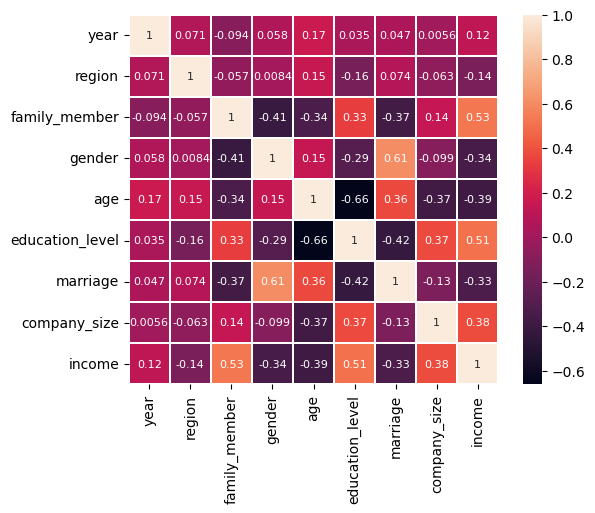

In [86]:
corr = df_w.corr()
sns.heatmap(corr, linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True, annot_kws = {'size':8})

<AxesSubplot:>

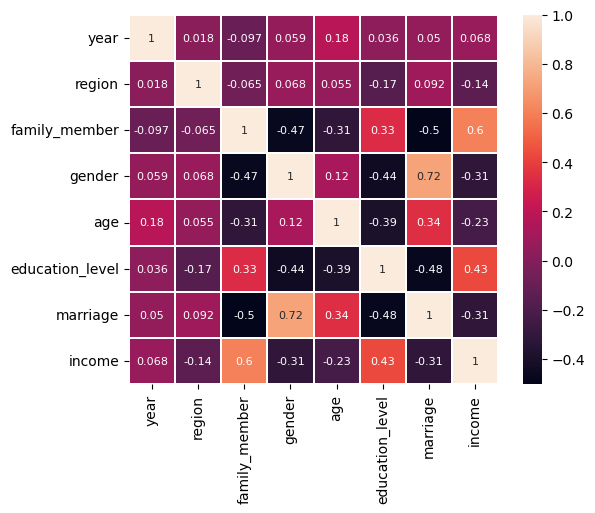

In [87]:
corr = df_n.corr()
sns.heatmap(corr, linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True, annot_kws = {'size':8})

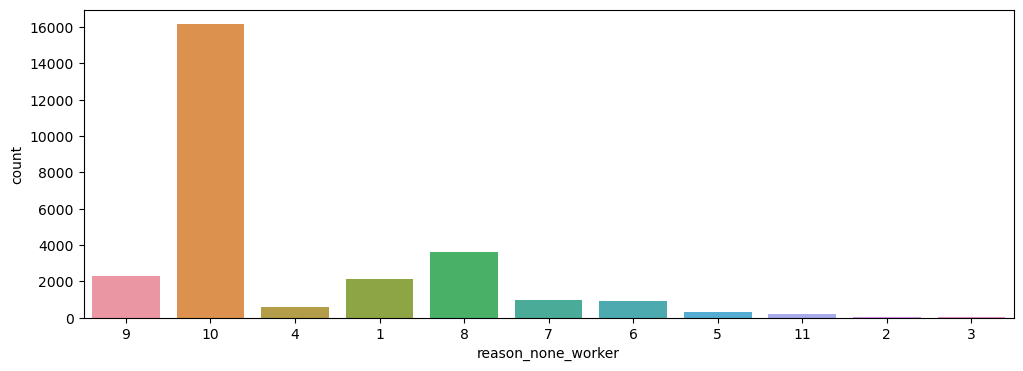

In [88]:
fig= plt.subplots(figsize=(12, 4))
sns.countplot(data=df_n, x=n_category[2])
plt.show()

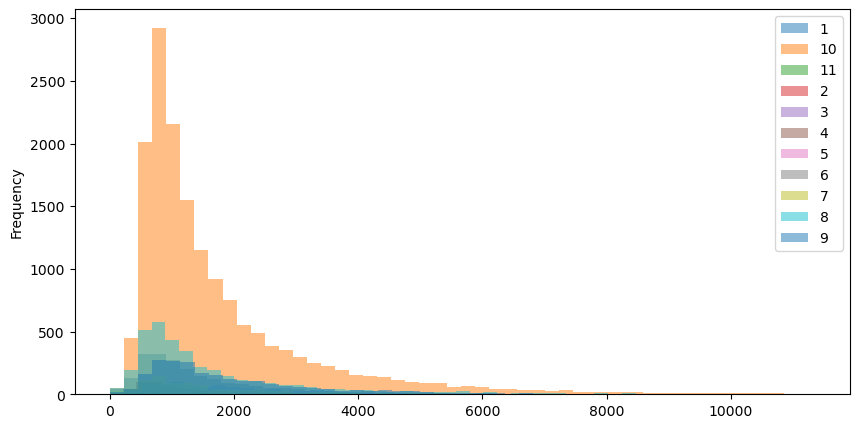

In [89]:
grouped = df_n.groupby('reason_none_worker')['income'].describe()

# 히스토그램 그리기
fig, ax = plt.subplots(figsize=(10, 5))
for idx, row in grouped.iterrows():
    df_n.loc[df_n['reason_none_worker']==idx, 'income'].plot(kind='hist', bins=50, alpha=0.5, ax=ax, label=idx)
ax.legend()
plt.show()

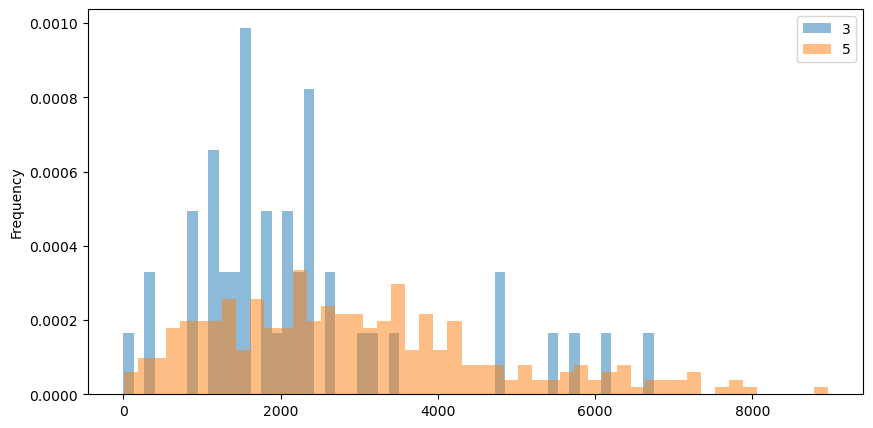

In [90]:
grouped = df_n[df_n['reason_none_worker'].isin(['3', '5'])].groupby('reason_none_worker')['income'].describe()
fig, ax = plt.subplots(figsize=(10, 5))
for idx, row in grouped.iterrows():
    df_n[df_n['reason_none_worker']==idx]['income'].plot(kind='hist', bins=50, alpha=0.5, ax=ax, label=idx, density=True)
ax.legend()
plt.show() 

In [91]:
df_n['reason_none_worker'] = df_n['reason_none_worker'].replace({9:1, 7:6})

/var/folders/1s/tzyglg092tj7kzxy4627gr2w0000gp/T/ipykernel_62452/2693916391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n['reason_none_worker'] = df_n['reason_none_worker'].replace({9:1, 7:6})


In [92]:
df_w_dum = pd.get_dummies(df_w[w_category])
df_n_dum = pd.get_dummies(df_n[n_category])

In [93]:
data_w = pd.DataFrame()
data_w = pd.concat([df_w_dum , df_w[w_num]] , axis = 1)
data_w.shape

(47316, 15)

In [94]:
data_w

,region,marriage,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,family_member,age,education_level,company_size
0,3,1.0,0,0,0,0,0,1,0,0,0,1,66,1,1
2,2,0.0,0,0,0,0,1,0,0,0,0,3,46,5,1
3,4,0.0,0,0,0,0,0,1,0,0,0,5,65,2,1
5,3,0.0,0,0,0,0,0,0,0,0,1,3,71,3,3
7,3,0.0,0,1,0,0,0,0,0,0,0,4,41,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78920,2,0.0,0,0,0,0,0,0,0,0,1,5,36,4,1
78921,4,0.0,0,0,0,0,0,1,0,0,0,2,70,3,1
78923,2,0.0,0,0,0,0,0,0,0,0,1,4,43,4,5
78924,2,0.0,0,0,0,0,1,0,0,0,0,4,35,4,2


In [95]:
data_n = pd.DataFrame()
data_n = pd.concat([df_n_dum , df_n[n_num]] , axis = 1)
data_n.shape

(27192, 16)

In [96]:
data_n

,region,marriage,reason_none_worker_1,reason_none_worker_10,reason_none_worker_11,reason_none_worker_2,reason_none_worker_3,reason_none_worker_4,reason_none_worker_5,reason_none_worker_6,reason_none_worker_7,reason_none_worker_8,reason_none_worker_9,family_member,age,education_level
1,4,0.0,0,0,0,0,0,0,0,0,0,0,1,3,80,4
4,4,0.0,0,1,0,0,0,0,0,0,0,0,0,2,78,1
10,4,1.0,0,1,0,0,0,0,0,0,0,0,0,1,74,2
17,4,0.0,0,1,0,0,0,0,0,0,0,0,0,2,86,2
19,6,1.0,0,0,0,0,0,1,0,0,0,0,0,1,81,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78917,4,1.0,0,0,0,0,0,1,0,0,0,0,0,1,71,1
78918,4,0.0,0,1,0,0,0,0,0,0,0,0,0,1,71,2
78922,4,1.0,1,0,0,0,0,0,0,0,0,0,0,1,83,1
78925,2,0.0,0,0,0,0,0,0,0,0,1,0,0,4,66,1
